In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

In [2]:
keras.utils.set_random_seed(15151515)

In [3]:
df_train = pd.read_csv('data/tr80.csv')
df_test = pd.read_csv('data/tt20.csv')

In [4]:
df_train.describe()

,Unnamed: 0,ID,CLASS,B7_1,B7_2,B7_3,B7_4,B7_5,B7_6,B7_7,...,B4_3,B4_4,B4_5,B4_6,B4_7,B4_8,B4_9,B4_10,B4_11,B4_12
count,12140.000000,12140.000000,12140.000000,7363.000000,4313.000000,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,...,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,12130.000000,12137.000000,11813.000000,11445.000000,4055.000000
mean,6069.500000,7619.770181,8.340857,1608.827889,1720.006086,1510.175408,1845.876953,2613.479634,3405.248679,3432.516565,...,904.410846,943.534499,879.852440,866.655752,936.175972,947.397918,1005.228640,987.131508,920.339428,1087.467263
std,3504.660469,4445.453009,5.599224,1235.039249,1249.205711,776.402814,858.231710,1202.509465,1232.234781,1413.421517,...,519.929347,523.610878,556.097036,546.556647,636.263642,573.896767,534.294807,547.096558,681.492656,1299.846852
min,0.000000,2.000000,1.000000,1.000000,1.000000,13.000000,28.000000,88.000000,84.000000,99.000000,...,31.000000,79.000000,80.000000,111.000000,91.000000,55.000000,72.000000,1.000000,1.000000,1.000000
25%,3034.750000,3780.750000,3.000000,868.500000,1073.500000,949.125000,1200.000000,1648.500000,2603.000000,2421.000000,...,595.000000,636.000000,500.750000,529.000000,469.000000,554.125000,688.500000,659.000000,530.000000,406.500000
50%,6069.500000,7596.500000,7.000000,1327.000000,1469.000000,1424.500000,1774.000000,2536.500000,3433.000000,3260.000000,...,819.500000,837.250000,785.000000,746.000000,740.000000,856.000000,926.500000,896.000000,766.500000,717.000000
75%,9104.250000,11439.250000,11.000000,1936.500000,1965.500000,1956.000000,2388.750000,3444.000000,4235.000000,4483.000000,...,1079.375000,1116.000000,1094.000000,1054.000000,1258.000000,1216.000000,1209.000000,1188.000000,1111.000000,1237.000000
max,12139.000000,30219.000000,40.000000,13860.000000,11126.000000,6794.000000,9689.000000,7901.000000,7689.000000,11556.000000,...,7100.000000,9752.000000,6280.000000,9896.000000,6088.000000,6484.000000,6456.000000,15808.000000,10416.000000,11632.000000


In [5]:
bands = set()
dates = set()
for column in df_train.columns:
    if not column.startswith("B"):
        continue

    parts = column.split('_')
    if len(parts) != 2:
        continue

    if parts[0] not in bands:
        bands.add(parts[0])

    if parts[1] not in dates:
        dates.add(int(parts[1]))

bands = list(bands)
dates = list(dates)

bands.sort()
dates.sort()
dates = dates[3:-3]

drop_dates = [1, 2, 3, 10, 11, 12]

for date in drop_dates:
    for band in bands:
        df_train = df_train.drop(columns=[f"{band}_{date}"])
        df_test = df_test.drop(columns=[f"{band}_{date}"])

df_train = df_train.dropna()
df_test = df_test.dropna()

for band in bands:
    for date in dates:
        df_train[f"{band}_{date}"] = df_train[f"{band}_{date}"].fillna(20000) / 5000
        df_test[f"{band}_{date}"] = df_test[f"{band}_{date}"].fillna(20000) / 5000

df_train = df_train[df_train.groupby("CLASS")["CLASS"].transform('count').ge(20)]
df_test = df_test[df_test.groupby("CLASS")["CLASS"].transform('count').ge(20)]

In [6]:
print(f"Bands count: {len(bands)}")
print(bands)

print(f"Dates count: {len(dates)}")
print(dates)

Bands count: 12
['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
Dates count: 6
[4, 5, 6, 7, 8, 9]


In [7]:
train_classes = df_train["CLASS"].unique()
train_classes.sort()

print(len(train_classes))
print(train_classes)

21
[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 21 26 34]


In [8]:
from feature_optimization import FeatureOptimizer
import feature_opt_functions as funcs
from indices import *

In [9]:
def get_OneVsOthers(df, class_N):
    one = df.loc[df["CLASS"] == class_N]
    others = df.loc[df["CLASS"] != class_N]
    return one, others

def get_Data(date, one, zero):
    BANDS = bands

    data_one = np.empty((len(bands), len(one)))
    data_zero = np.empty((len(bands), len(zero)))
    data = [data_zero, data_one]

    for i in range(len(BANDS)):
        data_one[i, :] = one[f"{BANDS[i]}_{date}"]
        data_zero[i, :] = zero[f"{BANDS[i]}_{date}"]

    return data

In [10]:
encoder = IndicesClassEncoderEq([Hue], list(range(len(bands))))
print(encoder.total_length)

args = { 
    "num_generations":100, 
    "num_parents_mating":2,
    "parent_selection_type":"sss",
    "keep_elitism":1,
    "sol_per_pop":100,
    "mutation_probability":0.15,
    "parallel_processing":8
}

total_features = set()
for name in train_classes:
    one, zero = get_OneVsOthers(df_train, name)

    best_features = None
    fitness = -100
    for date in dates:
        opt = FeatureOptimizer(encoder, 4,
                        funcs.bhattacharyya_distance, 
                        funcs.spearman_independency, 
                        optimization_method="genetic",
                        optimizer_args=args,
                        informativeness_threshold=0.0, 
                        independency_threshold=0.0,
                        set_independency="geometric_mean")
        
        data = get_Data(date, one, zero)

        print(f"'{name} ({len(one)})' vs 'all ({len(zero)})' at {date}:")
        opt.fit(data, data[1], True)

        new_fitness = opt.get_fitness_()
        if new_fitness > fitness:
            fitness = new_fitness
            best_features = opt.selected_features

        print(f"Selected features: {opt.selected_features}")
        print(f"-----------------------------------------")

    if not (best_features is None) and len(best_features) > 0:
        for feature in best_features:
            if not feature in total_features:
                total_features.add(feature)

1728
'1 (415)' vs 'all (11142)' at 4:


e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
e:\STUDY\deep-learning-2024\feature_opt_functions.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(d1, d2, nan_policy="omit")


Fitness (Gen 100): 1.0393970032395579
Selected features: [1065, 451, 846, 505]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 5:
Fitness (Gen 100): 1.5033115121678584
Selected features: [255, 1107, 1353, 1381]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 6:
Fitness (Gen 100): 2.4183596382817987
Selected features: [123, 834, 1526, 642]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 7:
Fitness (Gen 100): 1.9886731044935675
Selected features: [1353, 621, 1644, 1526]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 8:
Fitness (Gen 100): 1.8633769851326392
Selected features: [657, 223, 974, 1337]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 9:
Fitness (Gen 100): 1.2818499887137653
Selected features: [1275, 913, 1368, 1538]
-----------------------------------------
'2 (2194)' vs 'all (9363)' at 4:
Fitness (Gen 100): 0.445357987563805
Selected features: [304, 982, 589

In [11]:
total_features = list(total_features)
print("Total:", len(total_features))

Total: 83


In [12]:
def get_BigData(df, total_features):
    bigdata = np.empty((len(dates), len(total_features), len(df)))

    for date_i in range(len(dates)):
        data = np.empty((len(bands), len(df)))

        BANDS = bands
        for i in range(len(BANDS)):
            data[i, :] = df[f"{BANDS[i]}_{dates[date_i]}"]

        for feature_i in range(len(total_features)):
            bigdata[date_i, feature_i, :] = encoder.getIndex(total_features[feature_i]).getValue(data)

    return bigdata.swapaxes(1, 2).swapaxes(0, 1)

In [13]:
mapper = [None]*41
for i in range(len(train_classes)):
    mapper[train_classes[i]] = i

In [14]:
def pd_2_mts_XY(df):
    X = np.empty((df.shape[0], len(dates), len(bands)))
    Y = np.zeros((df.shape[0], len(train_classes)))

    counter = 0
    for _, row in df.iterrows():
        for date_i in range(len(dates)):
            for band_i in range(len(bands)):
                X[counter, date_i, band_i] = row[f"{bands[band_i]}_{dates[date_i]}"]
        
        Y[counter, mapper[int(row["CLASS"])]] = 1
        counter += 1

    return X, Y


In [15]:
train_X = get_BigData(df_train, total_features)
test_X = get_BigData(df_test, total_features)

_, train_Y = pd_2_mts_XY(df_train)
_, test_Y = pd_2_mts_XY(df_test)

In [16]:
print(train_X.shape)

(11557, 6, 83)


In [31]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(len(dates), train_X.shape[2])),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.GRU(32),
        keras.layers.Dense(len(train_classes), activation="softmax")
    ]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)             │ (None, 6, 83)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 6, 64)          │        28,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,709 (151.21 KB)

 Trainable params: 38,709 (151.21 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
print(train_X.min())
print(train_X.max())

-1.3595461582845847
1.3498918698749978


In [33]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy", "f1_score", "precision", "recall"],
)

In [34]:
history = model.fit(
    train_X,
    train_Y,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(test_X, test_Y)
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - categorical_accuracy: 0.2722 - f1_score: 0.0628 - loss: 2.5663 - precision: 0.3081 - recall: 0.0134 - val_categorical_accuracy: 0.5457 - val_f1_score: 0.1863 - val_loss: 1.4648 - val_precision: 0.7381 - val_recall: 0.2482
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.5638 - f1_score: 0.2363 - loss: 1.4379 - precision: 0.7268 - recall: 0.2860 - val_categorical_accuracy: 0.7070 - val_f1_score: 0.3399 - val_loss: 0.9458 - val_precision: 0.7932 - val_recall: 0.5513
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.6927 - f1_score: 0.3611 - loss: 1.0162 - precision: 0.7822 - recall: 0.5592 - val_categorical_accuracy: 0.7988 - val_f1_score: 0.4511 - val_loss: 0.6903 - val_precision: 0.8688 - val_recall: 0.7141
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.7567 - f1_score: 0.4430 - loss: 0.8011 - precision: 0.8242 - recall: 0.6862 - val_categorical_accu

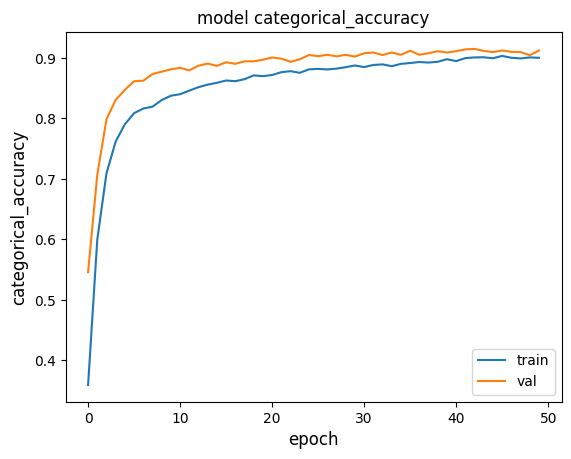

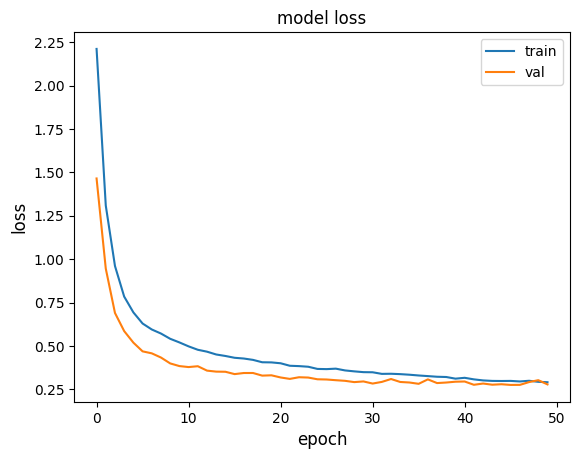

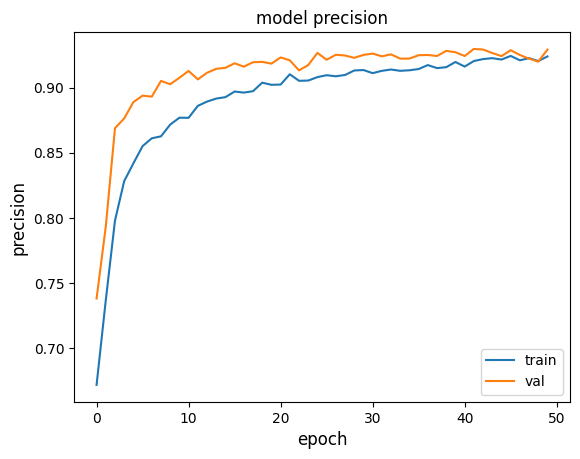

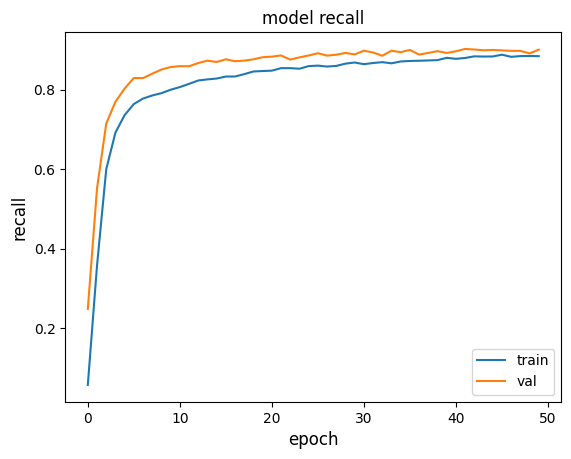

In [35]:
metrics = ["categorical_accuracy", "loss", "precision", "recall"]

for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [37]:
pred_train = np.argmax(model.predict(train_X), axis=1)
pred_test = np.argmax(model.predict(test_X), axis=1)

362/362 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [38]:
print(classification_report(np.argmax(train_Y, axis=1), pred_train))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       415
           1       0.92      0.95      0.94      2194
           2       0.99      0.97      0.98       382
           3       0.79      0.86      0.82        63
           4       0.96      0.99      0.98      1388
           5       0.91      0.85      0.88        62
           6       0.98      0.98      0.98      1544
           7       0.96      0.94      0.95       631
           8       0.98      0.99      0.98       632
           9       0.90      0.95      0.93      1624
          10       0.97      0.81      0.88       188
          11       0.95      0.96      0.96       568
          12       0.93      0.89      0.91       279
          13       0.82      0.77      0.79       685
          14       0.86      0.79      0.82       107
          15       0.72      0.63      0.67        81
          16       0.75      0.55      0.64       276
          17       0.87    

In [39]:
print(classification_report(np.argmax(test_Y, axis=1), pred_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        96
           1       0.93      0.93      0.93       544
           2       0.97      0.85      0.91        88
           3       0.00      0.00      0.00         0
           4       0.95      0.98      0.96       340
           6       0.98      0.96      0.97       380
           7       0.93      0.90      0.92       150
           8       0.96      0.98      0.97       146
           9       0.90      0.94      0.92       394
          10       0.92      0.82      0.87        40
          11       0.96      0.95      0.95       136
          12       0.89      0.80      0.84        60
          13       0.79      0.80      0.79       160
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.61      0.47      0.53        57
          17       0.86      0.91      0.88        67
          18       0.55    

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


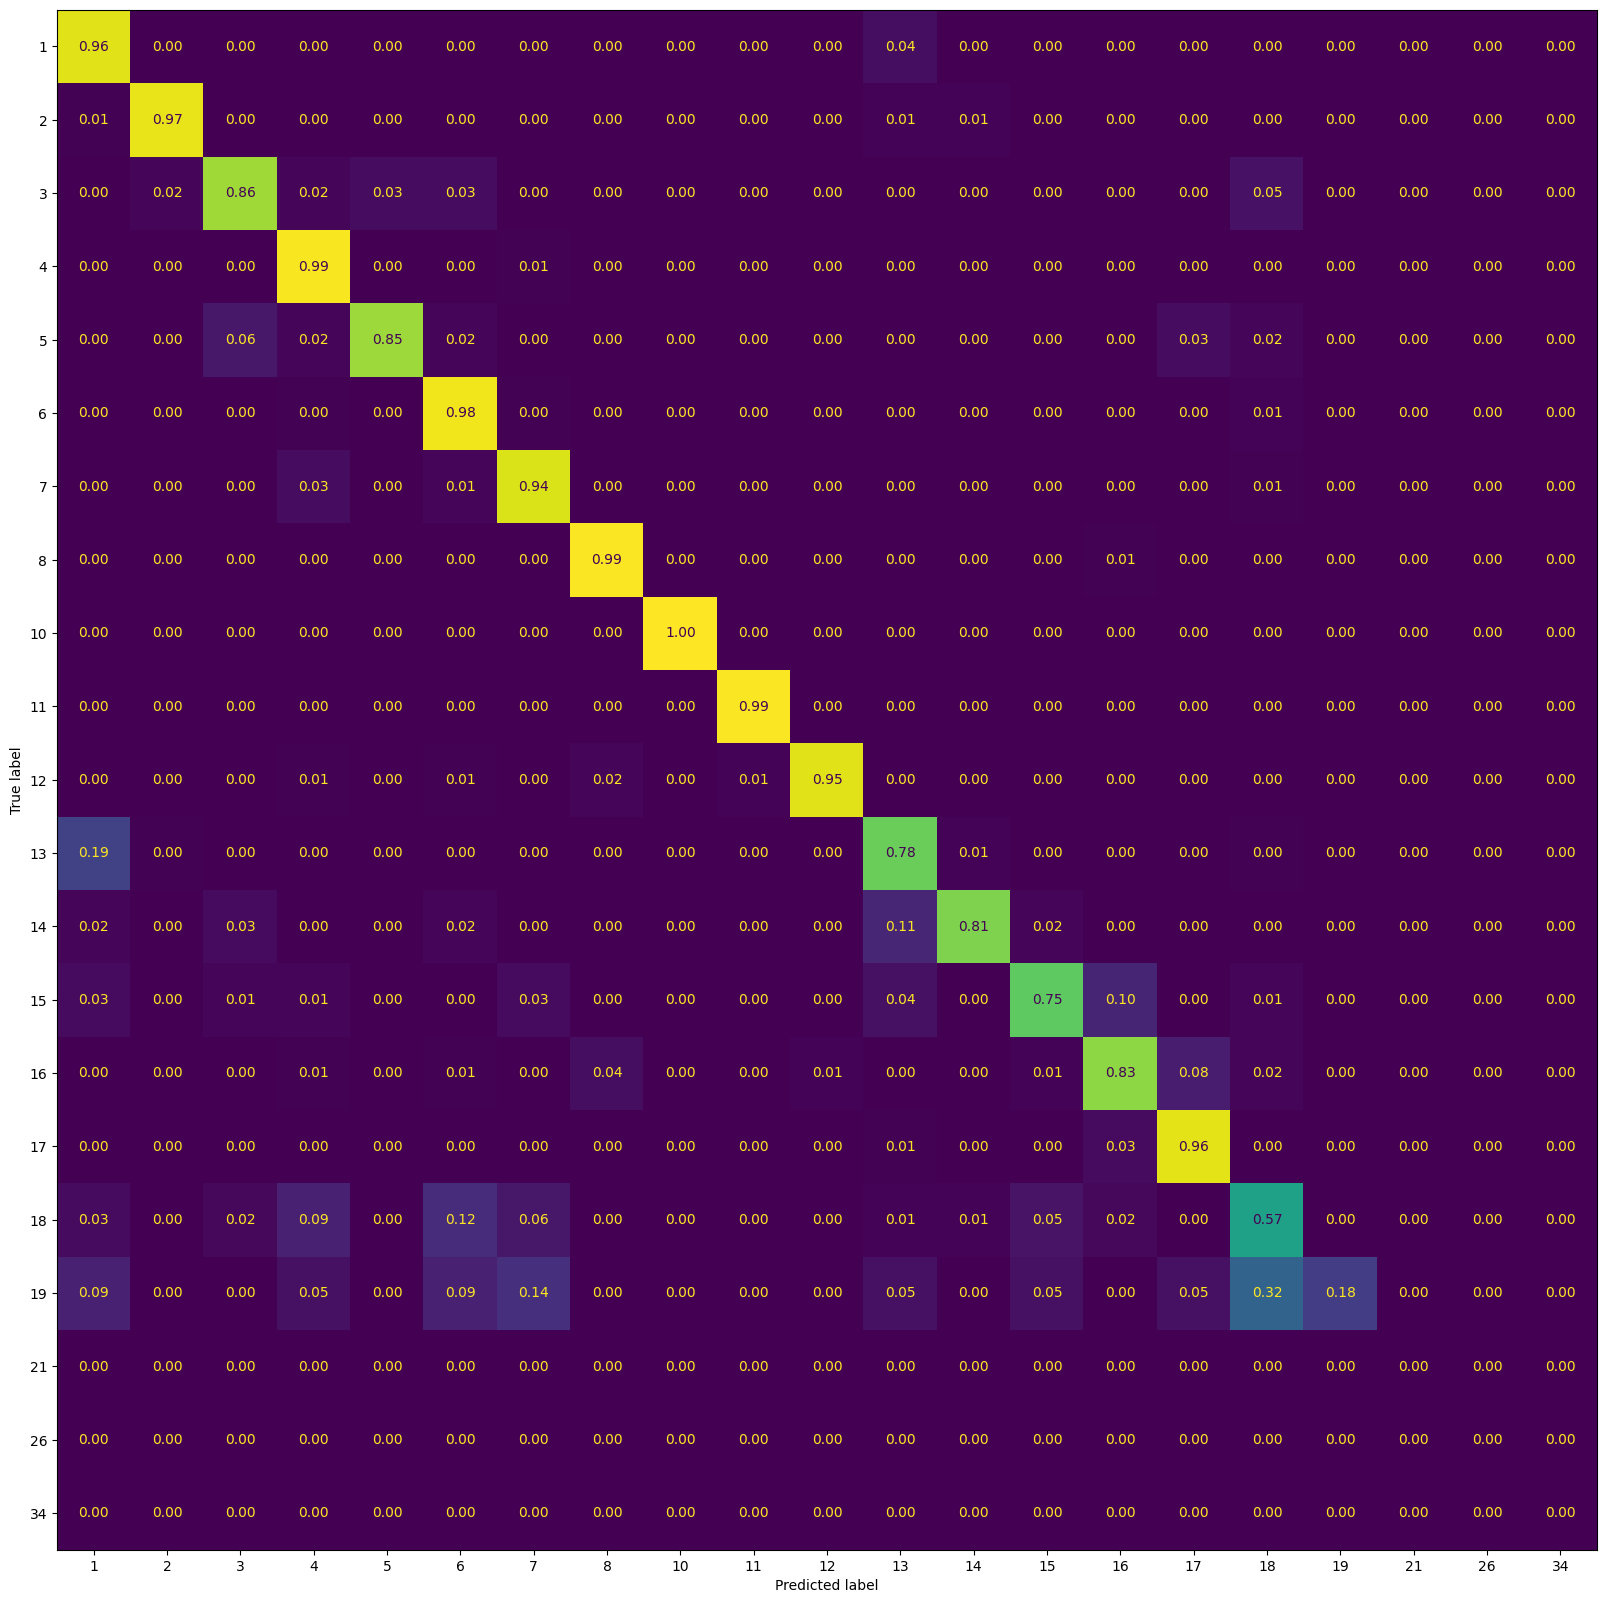

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(train_Y, axis=1), pred_train, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)

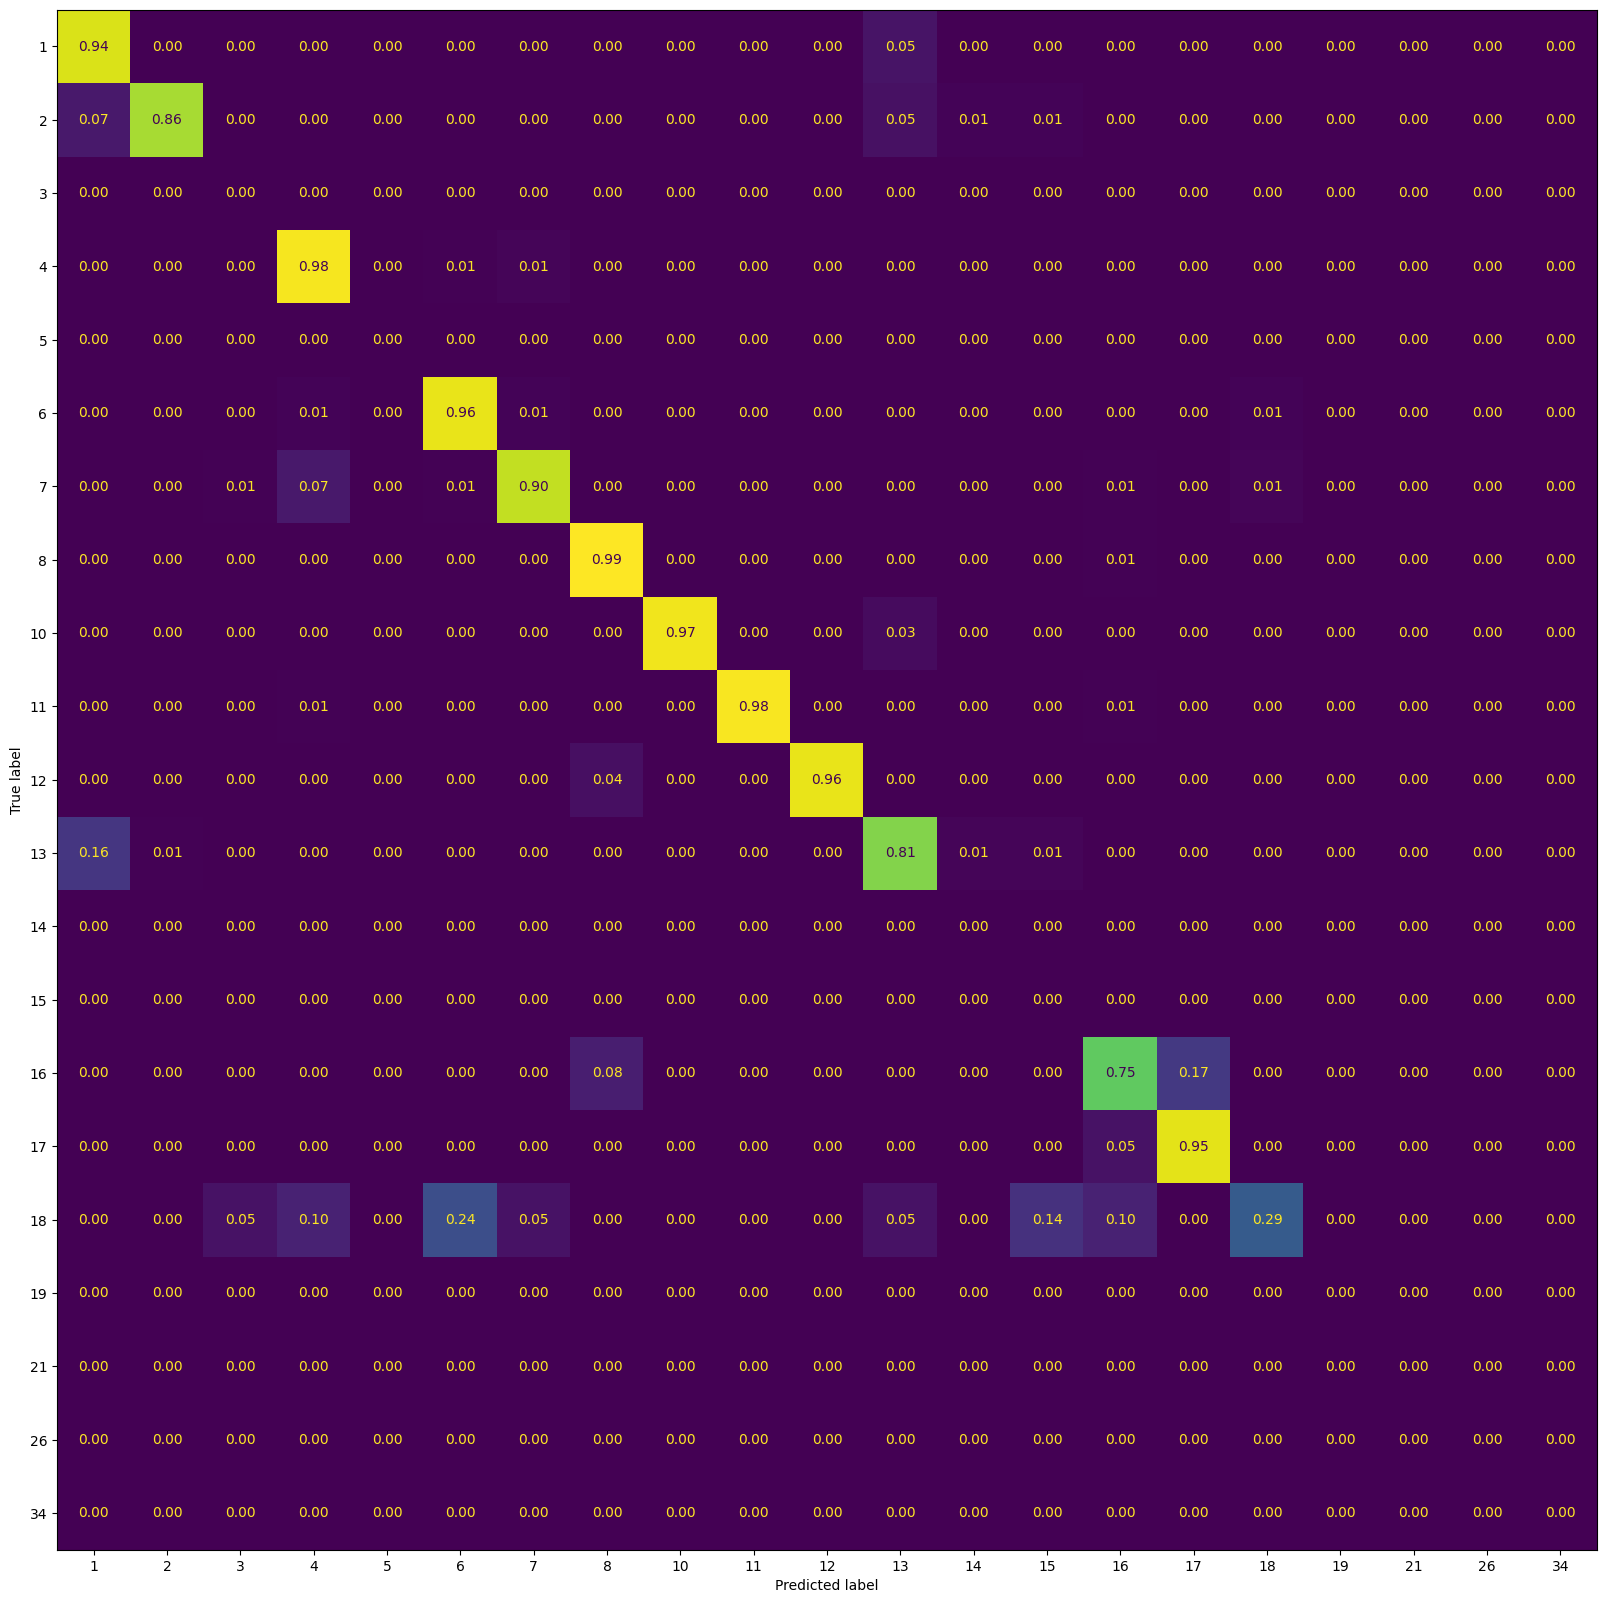

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(test_Y, axis=1), pred_test, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)